In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from selenobot.files import XMLFile 
import os
import sys
from typing import List, Tuple, Dict
import scipy.stats
import sklearn.neighbors
from selenobot.tools import Clusterer

sys.path.append('../scripts/')
from build import clean

%load_ext autoreload
%autoreload 2


DATA_DIR = '/home/prichter/Documents/selenobot/data/'

In [2]:
def digitize(values:np.ndarray, bin_edges:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''Assign a bin label to each input value using the specified bin edges.
    
    :param values: An array of values for which to assign bin labels. 
    :param bin_edges: The bin edges. The left and right-most edges are inclusive, and bins[i-1] <= x < bins[i]. 
    :return: A tuple containing (1) an array of size len(values) containing bin labels for each value, and (2) an array
        of size len(bin_edges) - 1 containing names for each bin. 
    '''
    # Numpy digitize does not include the right-most bin edge, but the histogram function does. This
    # leads to an annoying problem where the largest value is assigned an out-of-bounds bin value, unless
    # the right-most bin edge is incremented. 
    bin_edges[-1] = bin_edges[-1] + 1
    bin_labels = np.digitize(values, bin_edges)
    bin_names = [f'{int(bin_edges[i])}-{int(bin_edges[i + 1])}' for i in range(len(bin_edges) - 1)]
    return (bin_labels, bin_names)


def groupby(values:np.ndarray, keys:np.ndarray) -> Dict[int, np.ndarray]:
    '''Group the input array of values according to the corresponding keys.
    
    :param values: An array of values to group. 
    :param: An array of keys with the same shape as the values array. 
    :return: A dictionary mapping each key to a set of corresponding values.     
    '''
    sort_idxs = np.argsort(keys) # Get the indices which would put the keys in order. 
    sorted_values, sorted_keys = values[sort_idxs], keys[sort_idxs] # Sort the values and keys. 
    
    unique_keys, unique_idxs = np.unique(sorted_keys, return_index=True) 
    # unique_idxs will basically contain the index of the first location of each key (i.e. bin)
    binned_values = np.split(sorted_values, unique_idxs)[1:]
    return {int(key):value for key, value in zip(unique_keys, binned_values)}


def sample(values:np.ndarray, hist:np.ndarray, bin_edges:np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''Sample from a list of values according to the bins and bin heights from a histogram.
    
    :param values: An array of values to sample. 
    :param hist: The number of entries in each histogram bin; expect output from np.histogram. 
    :param bin_edges: The bin edges. The left and right-most edges are inclusive, and bins[i-1] <= x < bins[i]. 
    :return: A tuple containing a subsample of the values, which should follow the distribution of the input histogram,
        as well as the indices of the sample. 
    '''

    bin_labels, _ = digitize(values, bin_edges)
    bin_idxs = groupby(np.arange(len(values)), bin_labels)
    
    # Remove bins which are outside the histogram boundaries (i.e. are less than the minimum bin edge
    # or greater than the maximim bin edge).
    if 0 in bin_idxs:
        del bin_idxs[0]
    if len(bin_edges) in bin_idxs:
        del bin_idxs[len(bin_edges)]

    # Want to take the biggest sample possible while remaining in line with the input hist. 
    # scale = min([len(idxs) / hist[label - 1] for label, idxs in bin_idxs.items()])

    sample_idxs = []
    for label, idxs in bin_idxs.items():
        # n = int(scale * hist[label - 1])
        n = hist[label - 1]
        sample_idxs.append(np.random.choice(idxs, n, replace=False))
    sample_idxs = np.concat(sample_idxs).ravel()
    
    return (values[sample_idxs], sample_idxs)


# Dataset construction

In [3]:
uniprot_sprot_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sprot.csv'), index_col=0)
uniprot_sec_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot_sec.csv'), index_col=0)

In [4]:
uniprot_sec_df = clean(uniprot_sec_df, bacteria_only=True, allow_c_terminal_fragments=True, remove_selenoproteins=False)

original_seqs = uniprot_sec_df[['seq']].copy()
uniprot_sec_df['seq'] = uniprot_sec_df.seq.apply(lambda s : s.split('U')[0])
# Make sure to dereplicate based on the truncated sequences. 
clusterer = Clusterer(name='uniprot_sec', tool='cdhit')
uniprot_sec_df = clusterer.dereplicate(uniprot_sec_df, overwrite=True)

uniprot_sec_df = uniprot_sec_df.rename(columns={'seq':'seq_truncated'})
uniprot_sec_df = uniprot_sec_df.merge(original_seqs, left_index=True, right_index=True, how='inner')

clean: Removed 3216 non-bacterial proteins from the DataFrame. 16412 sequences remaining.
clean: Removed 0 proteins which exceed 2000 amino acids in length from the DataFrame. 16412 sequences remaining.
clean: Removed 244 fragment proteins from the DataFrame. 16168 sequences remaining.
cd-hit -i /home/prichter/Documents/selenobot/notebooks/uniprot_sec.fa -o /home/prichter/Documents/selenobot/notebooks/dereplicate_uniprot_sec -n 5 -c 0.95 -l 5
Clusterer.dereplicate: Dereplication of clusters with 0.95 similarity eliminated 5147 sequences from uniprot_sec. 11021 sequences remaining.


In [5]:
uniprot_sprot_df = clean(uniprot_sprot_df, bacteria_only=True, allow_c_terminal_fragments=False, remove_selenoproteins=True)

clean: Removed 235396 non-bacterial proteins from the DataFrame. 336468 sequences remaining.
clean: Removed 52 selenoproteins from the DataFrame. 336416 sequences remaining.
clean: Removed 140 proteins which exceed 2000 amino acids in length from the DataFrame. 336276 sequences remaining.
clean: Removed 1533 fragment proteins from the DataFrame. 334743 sequences remaining.


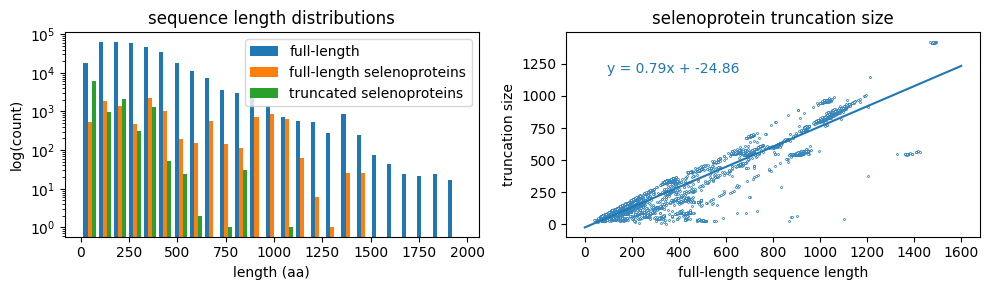

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))


axes[0].hist((uniprot_sprot_df.seq.apply(len), uniprot_sec_df.seq.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[0].set_yscale('log')
axes[0].legend(['full-length', 'full-length selenoproteins', 'truncated selenoproteins'])
axes[0].set_title('sequence length distributions')
axes[0].set_ylabel('log(count)')
axes[0].set_xlabel('length (aa)')


axes[1].set_xlabel('full-length sequence length')
axes[1].set_ylabel('truncation size')
axes[1].set_title('selenoprotein truncation size')

x = uniprot_sec_df.seq.apply(len)
y = uniprot_sec_df.seq.apply(len) - uniprot_sec_df.seq_truncated.apply(len)
m, b = np.polyfit(x, y, deg=1)

axes[1].scatter(x, y, s=2, facecolor='white', linewidth=0.5, edgecolor='tab:blue')
axes[1].plot(np.linspace(0, 1600), np.linspace(0, 1600) * m + b)
axes[1].text(0.1, 0.8, f'y = {np.round(m, 2)}x + {np.round(b, 2)}', transform=axes[1].transAxes, c='tab:blue')


plt.tight_layout()
plt.show()

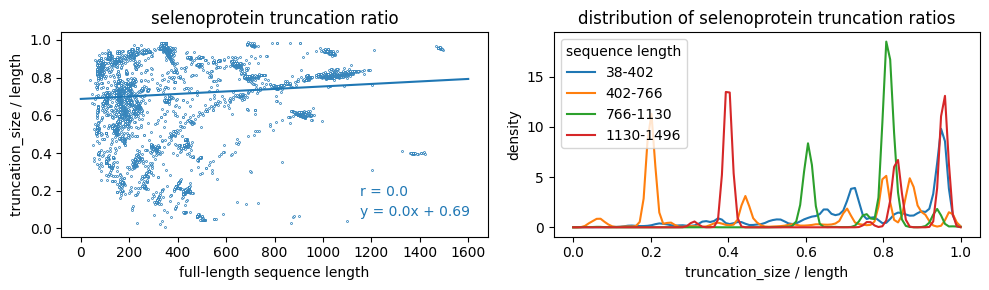

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].set_xlabel('full-length sequence length')
axes[0].set_ylabel('truncation_size / length')
axes[0].set_title('selenoprotein truncation ratio')

x = uniprot_sec_df.seq.apply(len)
y = (uniprot_sec_df.seq.apply(len) - uniprot_sec_df.seq_truncated.apply(len)) / uniprot_sec_df.seq.apply(len) 
m, b = np.polyfit(x, y, deg=1)
r = np.corrcoef(x, y) # Compute the strength and direction of the relationship between the variables. 

axes[0].scatter(x, y, s=2, facecolor='white', linewidth=0.5, edgecolor='tab:blue')
axes[0].plot(np.linspace(0, 1600), np.linspace(0, 1600) * m + b)
axes[0].text(0.7, 0.10, f'y = {np.round(m, 2)}x + {np.round(b, 2)}', transform=axes[0].transAxes, c='tab:blue')
axes[0].text(0.7, 0.2, f'r = {np.round(r[0, 1])}', transform=axes[0].transAxes, c='tab:blue')

# I think what I will try to do is generate a distribution for each length bin, and sample for truncation size. 
# Perhaps that will yield better results than randomly sampling from the fixed list, and will allow me to grab a bigger 
# subset of SwissProt for the third category. 

# I actually think that this might not be the best approach, as the truncation sizes per bin are pretty clearly not
# normally distributed. Instead, I think I will sample from the distribution of truncation ratios. 

# TODO: https://towardsdatascience.com/kernel-density-estimation-explained-step-by-step-7cc5b5bc4517 
# TODO: https://stackoverflow.com/questions/3510475/generate-random-numbers-according-to-distributions 

# Working with the de-replicated truncated sequences. 
sec_truncation_ratios = (uniprot_sec_df.seq.apply(len).values - uniprot_sec_df.seq_truncated.apply(len).values) / uniprot_sec_df.seq.apply(len).values
sec_lengths = uniprot_sec_df.seq.apply(len).values

hist, bin_edges = np.histogram(sec_lengths, bins=4)
bin_labels, bin_names = digitize(sec_lengths, bin_edges)

x = np.linspace(0, 1, 100)

legend = []
kdes = dict()
for bin_label, bin_values in groupby(sec_truncation_ratios, bin_labels).items():

    kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=0.01) 
    kde.fit(bin_values.reshape(-1, 1))
    kdes[bin_label] = kde

    y = np.exp(kde.score_samples(x.reshape(-1, 1)).ravel())
    axes[1].plot(x, y)
    legend.append(bin_names[bin_label - 1])

axes[1].set_xlabel('truncation_size / length')
axes[1].set_ylabel('density')
axes[1].set_title('distribution of selenoprotein truncation ratios')
axes[1].legend(legend, title='sequence length')

plt.tight_layout()
plt.show()

# NOTE: There appears to be very little correlation between length of the original sequence and the amount of the
# sequence which is truncated. However, it is pretty clear that the data are heteroscedastic. To properly reproduce the 
# distribution, I am going to try binning by length first. 

In [8]:
def truncate(df:pd.DataFrame, sec_seqs:np.ndarray, n_bins:int=25, bandwidth:float=0.01) -> pd.DataFrame:
    '''Sub-sample the set of all full-length proteins such that the length distribution matches that of the full-length
    selenoproteins. Then, truncate the sampled sequences so that the truncated length distributions also match.

    :param df: The DataFrame containing the complete set of SwissProt proteins. 
    :param sec_seqs: A Numpy array containing the full-length selenoprotein sequences. 
    :param n_bins: The number of bins to use for producing a length distribution of full-length selenoproteins. 
        This is used when initially down-sampling SwissProt. 
    :param bandwidth: The bandwidth to use for the kernel density estimation, which is used for creating 
        distributions for selecting truncation ratios. 
    :return: A pandas DataFrame containing the sub-sampled and randomly truncated SwissProt proteins. 
    '''
    sec_seqs_truncated = np.array([seq.split('U')[0] for seq in sec_seqs])
    sec_lengths = np.array([len(seq) for seq in sec_seqs])
    sec_lengths_truncated = np.array([len(seq) for seq in sec_seqs_truncated]) 

    sec_truncation_ratios = (sec_lengths - sec_lengths_truncated) / sec_lengths

    hist, bin_edges = np.histogram(sec_lengths, bins=n_bins)
    bin_labels, bin_names = digitize(sec_lengths, bin_edges)

    _, idxs = sample(df.seq.apply(len).values, hist, bin_edges)
    df = df.iloc[idxs].copy()
    df['bin_label'], _ = digitize(df.seq.apply(len).values, bin_edges)

    kdes = dict()
    for bin_label, bin_values in groupby(sec_truncation_ratios, bin_labels).items():
        kde = sklearn.neighbors.KernelDensity(kernel='gaussian', bandwidth=bandwidth) 
        kde.fit(bin_values.reshape(-1, 1))
        kdes[bin_label] = kde

    df_truncated = []
    for bin_label, bin_df in df.groupby('bin_label'):
        bin_df['truncation_size'] = kdes[bin_label].sample(n_samples=len(bin_df)).ravel() * bin_df.seq.apply(len).values
        bin_df['seq'] = bin_df.apply(lambda row : row.seq[:-int(row.truncation_size)], axis=1)
        df_truncated.append(bin_df)

    return pd.concat(df_truncated)



## Binary classification

For binary classification, the goal is to train a model to distinguish between full-length non-selenoproteins and truncated selenoproteins. For this task, we have two datasets:
1. All of the non-fragmented proteins in SwissProt, with the selenoproteins removed. 
2. All selenoproteins registered in UniProt, truncated at the first selenocysteine residue. 

**Problem:** The binary model, when run on GTDB, seems to be flagging too many sequences as selenoproteins. There are several possibilities for what might be happening: (1) There are actually tons of truncated selenoproteins, which seems unlikely, (2) there are full-length which kind of resemble truncated selenoproteins that are being flagged, (3) there are truncated proteins that are not selenoproteins. 

In [9]:
# Want to take a look at the datasets a bit. 


## Ternary classification

For ternary classification, the goal is to train a model to distinguish between full-length non-selenoproteins, truncated selenoproteins, and truncated non-selenoproteins. The reasoning behind this is to determine if the "false positives" I think the model is classifying as truncated selenoproteins might simply be truncated regular proteins. However, I really have no sense as to whether or not these hits are being identified because they specifically look like truncated selenoproteins (i.e., similar in length, composition, or something else), or just because they are truncated. 

1. Randomly sub-sample with replacement (for convenience, I used the same size sample as the selenoprotein subset) from the non-dereplicated SwissProt database. Ensure that the length distribution of the subsample matches the full-length selenoproteins, and that none of the sampled sequences are full-length selenoproteins. 
2. Truncate the sub-sampled sequences according to their length. The resulting length distribution of the truncated selenoproteins matches the distribution of the truncated selenoproteins. 
3. De-replicate the truncated non-selenoproteins. 



In [11]:
# longest_sec = max(uniprot_sec_df.seq.apply(len))
# print('Longest full-length selenoproteins:', longest_sec)

original_seqs = uniprot_sprot_df[['seq']].copy()

uniprot_sprot_sample_df = truncate(uniprot_sprot_df.copy(), sec_seqs=uniprot_sec_df.seq.values, n_bins=10)
uniprot_sprot_sample_df = uniprot_sprot_sample_df.rename(columns={'seq':'seq_truncated'})
uniprot_sprot_sample_df = uniprot_sprot_sample_df.merge(original_seqs, left_index=True, right_index=True, how='inner')

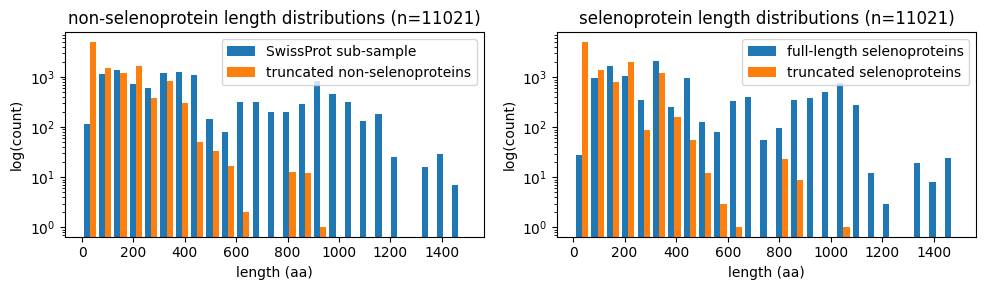

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len)), bins=25)
# axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[0].set_yscale('log')
axes[0].set_ylabel('log(count)')
axes[0].set_xlabel('length (aa)')
axes[0].legend(['SwissProt sub-sample', 'truncated non-selenoproteins'])
axes[0].set_title(f'non-selenoprotein length distributions (n={len(uniprot_sprot_sample_df)})')

axes[1].hist((uniprot_sec_df.seq.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
# axes[0].hist((uniprot_sprot_sample_df.seq.apply(len), uniprot_sprot_sample_df.seq_truncated.apply(len), uniprot_sec_df.seq_truncated.apply(len)), bins=25)
axes[1].set_yscale('log')
axes[1].set_ylabel('log(count)')
axes[1].set_xlabel('length (aa)')
axes[1].legend(['full-length selenoproteins', 'truncated selenoproteins'])
axes[1].set_title(f'selenoprotein length distributions (n={len(uniprot_sec_df)})')

plt.tight_layout()
plt.show()

In [ ]:
# # API URL for retrieving bacterial proteins which are non-TrEMBL reviewed, and have evidence at the transcript level. 
# # See this link for more info on protein existence: https://www.uniprot.org/help/protein_existence
# # https://rest.uniprot.org/uniprotkb/stream?compressed=true&format=xml&query=%28%28taxonomy_id%3A2%29%29+AND+%28reviewed%3Afalse%29+AND+%28existence%3A2%29

# xml_file = NcbiXmlFile(os.path.join(DATA_DIR, 'uniprot_trembl.xml'))
# xml_file.to_df().to_csv(os.path.join(DATA_DIR, 'uniprot_trembl.csv'))